# CRA5 inference demo

In [1]:
import math
import io
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## 1.inference

### Download initial data from ERA5 

In [2]:
local_root= '../data/ERA5'
time_stamp="2024-06-01T00:00:00"
current_dir = os.getcwd()
new_dir = "/mnt/petrelfs/hantao.dispatch/NWP/CRA5/examples"  # 替换为您想要切换到的新目录路径
os.chdir(new_dir)

print(current_dir)
from era5_downloader import era5_downloader
ERA5_data = era5_downloader('./era5_config.py')
data = ERA5_data.get_form_timestamp(time_stamp=time_stamp,
                                    local_root=local_root)



/mnt/petrelfs/hantao.dispatch/project/yangchuang
2024-06-01 00:00:00
File is saved to ../data/ERA5/2024/2024-06-01T00:00:00_pressure.nc


2024-07-01 19:51:48,073 INFO Welcome to the CDS
2024-07-01 19:51:48,073 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-pressure-levels
2024-07-01 19:51:48,352 INFO Request is completed


../data/ERA5/2024/2024-06-01T00:00:00_pressure.nc is complete, remote vs local size: 537820128==537820128
../data/ERA5/2024/2024-06-01T00:00:00.nc has been fully downloaded, No need to down it again !!!
File is saved to ../data/ERA5/2024/2024-06-01T00:00:00_single.nc


2024-07-01 19:51:48,790 INFO Welcome to the CDS
2024-07-01 19:51:48,791 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels


../data/ERA5/2024/2024-06-01T00:00:00_single.nc is complete, remote vs local size: 18700164==18700164
../data/ERA5/2024/2024-06-01T00:00:00.nc has been fully downloaded, No need to down it again !!!


### Load weather data and convert to 4D float tensor

In [3]:
import xarray as xr
import numpy as np
import json

vnames=dict(
    pressure=['z','q', 'u', 'v', 't', 'r','w'],
    single=['v10','u10','v100', 'u100', 't2m','tcc', 'sp','tp', 'msl']) # 'tisr'


total_levels = [1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,
 775.,  750.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,
 350.,  300.,  250.,  225.,  200.,  175.,  150.,  125.,  100.,
 70.,   50.,   30.,   20.,   10.,    7.,    5.,    3.,    2.,
 1.]

pressure_level = total_levels

level_mapping = [total_levels.index(val) for val in pressure_level if val in total_levels ]

pressure_file = f'{local_root}/{time_stamp[:4]}/{time_stamp}_pressure.nc'
single_file = f'{local_root}/{time_stamp[:4]}/{time_stamp}_single.nc'

pressure_data = xr.open_dataset(pressure_file, 
                                engine='netcdf4',
                                )
single_data = xr.open_dataset(single_file, 
                                engine='netcdf4',
                                  )
print(pressure_data, single_data)   

def get_mean_std():
    with open('./mean_std.json',mode='r') as f:
        mean_std = json.load(f)
        f.close()
    with open('./mean_std_single.json',mode='r') as f:
        mean_std_single = json.load(f)
        f.close()

    mean_list, std_list = [],[]
    for  vname in vnames.get('pressure'):
        mean_list += [mean_std['mean'][vname][idx] for idx in level_mapping]
        std_list += [mean_std['std'][vname][idx] for idx in level_mapping]

    for vname in vnames.get('single'):
        mean_list.append(mean_std_single['mean'][vname])
        std_list.append(mean_std_single['std'][vname])
        
    return dict(mean=np.array(mean_list,dtype=np.float32), std=np.array(std_list, dtype=np.float32))

def normalization( data):
    mean_std = get_mean_std()
    data = data - mean_std['mean'][:,np.newaxis,np.newaxis]
    data = data / mean_std['std'][:,np.newaxis,np.newaxis]
    return data

channels_to_vname={}
vname_to_channels={}
ch_idx = 0
for v in vnames.get('pressure'):
    for level in pressure_level:
        channels_to_vname.update({ch_idx: v+'_'+str(int(level)) })
        vname_to_channels.update({v+'_'+str(int(level)): ch_idx })
        ch_idx += 1
for v in vnames.get('single'):
    channels_to_vname.update({ch_idx: v })
    vname_to_channels.update({v: ch_idx})
    ch_idx += 1
print(channels_to_vname)
print(vname_to_channels)

def read_data_from_grib():
    hours = pressure_data.time.data
    one_step= []

    for vname in vnames.get('pressure'):
        D = pressure_data[vname].data
        Pha_levels = list(pressure_data.level.data)

        level_mapping =  [Pha_levels.index(val) for val in pressure_level if val in Pha_levels]
        for level in level_mapping:
            one_step.append(D[0][level][None])
    for vname in vnames.get('single'):
        D = single_data[vname].data
        if vname == 'tp':
            D = D * 1000
            print(D.max(), D.min())
        one_step.append(D)

    one_step = np.concatenate(one_step,0)

    return one_step
input_data = read_data_from_grib()
input_data_norm = normalization(input_data)

print(input_data.shape)

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, level: 37, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * level      (level) int32 1 2 3 5 7 10 20 30 ... 850 875 900 925 950 975 1000
  * time       (time) datetime64[ns] 2024-06-01
Data variables:
    z          (time, level, latitude, longitude) float32 ...
    r          (time, level, latitude, longitude) float32 ...
    q          (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    u          (time, level, latitude, longitude) float32 ...
    v          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-30 14:52:06 GMT by grib_to_netcdf-2.28.1: /opt/ecmw... <xarray.Dataset>
Dimensions:    (longitude: 1

### Visualize input data

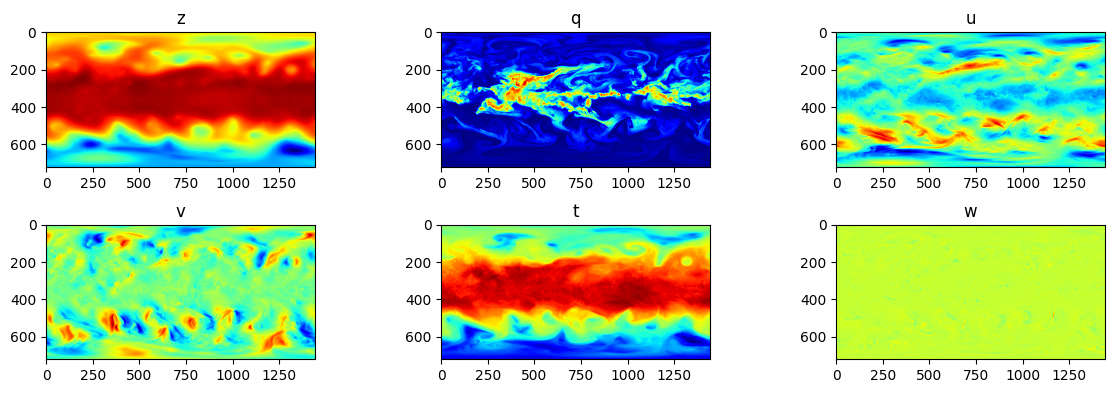

In [4]:
import numpy as np
import matplotlib.pyplot as plt

z_data = pressure_data['z'].sel(level=500).squeeze()
q_data = pressure_data['q'].sel(level=500).squeeze()
u_data = pressure_data['u'].sel(level=500).squeeze()
v_data = pressure_data['v'].sel(level=500).squeeze()
t_data = pressure_data['t'].sel(level=500).squeeze()
w_data = pressure_data['w'].sel(level=500).squeeze()

fig, axs = plt.subplots(2, 3, figsize=(12, 4))

# z
axs[0, 0].imshow(z_data, cmap='jet')
axs[0, 0].set_title('z')

# q
axs[0, 1].imshow(q_data, cmap='jet')
axs[0, 1].set_title('q')

# u
axs[0, 2].imshow(u_data, cmap='jet')
axs[0, 2].set_title('u')

# v
axs[1, 0].imshow(v_data, cmap='jet')
axs[1, 0].set_title('v')

# t
axs[1, 1].imshow(t_data, cmap='jet')
axs[1, 1].set_title('t')

# t
axs[1, 2].imshow(w_data, cmap='jet')
axs[1, 2].set_title('w')


plt.tight_layout()

plt.show()

### Load a pretrained model

In [5]:
import os 
from torchvision import transforms
import torch
os.environ['http_proxy']='http://10.1.11.100:8086/'
os.environ['HTTP_PROXY']='http://10.1.11.100:8086/'
os.environ['https_proxy']='http://10.1.11.100:8086/'
os.environ['HTTPS_PROXY']='http://10.1.11.100:8086/'
from cra5.models.compressai.zoo import bmshj2018_factorized
from cra5.models.compressai.zoo import vaeformer_pretrained
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
# net = bmshj2018_factorized(quality=2, pretrained=True)
net = vaeformer_pretrained(quality=268, pretrained=True).eval().to(device)
x = torch.from_numpy(input_data_norm).unsqueeze(0).to(device)
print(x.shape)
with torch.no_grad():
    out_net = net.forward(x) 
    
print(out_net)
    

cuda
torch.Size([1, 268, 721, 1440])


/mnt/petrelfs/hantao.dispatch/anaconda3/envs/nwp/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


{'x_hat': tensor([[[[ 0.7833,  0.7840,  0.7832,  ...,  0.7853,  0.7836,  0.7791],
          [ 0.7899,  0.7907,  0.7909,  ...,  0.7926,  0.7925,  0.7913],
          [ 0.7683,  0.7685,  0.7693,  ...,  0.7720,  0.7723,  0.7735],
          ...,
          [-0.1317, -0.1330, -0.1317,  ..., -0.1398, -0.1395, -0.1380],
          [-0.1537, -0.1561, -0.1557,  ..., -0.1613, -0.1605, -0.1581],
          [-0.1531, -0.1552, -0.1580,  ..., -0.1422, -0.1427, -0.1371]],

         [[ 0.6712,  0.6720,  0.6713,  ...,  0.6750,  0.6735,  0.6696],
          [ 0.6759,  0.6761,  0.6764,  ...,  0.6782,  0.6779,  0.6770],
          [ 0.6575,  0.6580,  0.6586,  ...,  0.6609,  0.6610,  0.6620],
          ...,
          [-0.2790, -0.2800, -0.2788,  ..., -0.2857, -0.2850, -0.2827],
          [-0.2965, -0.2988, -0.2985,  ..., -0.3026, -0.3015, -0.2989],
          [-0.2972, -0.2993, -0.3016,  ..., -0.2865, -0.2862, -0.2809]],

         [[ 0.5604,  0.5613,  0.5606,  ...,  0.5645,  0.5634,  0.5604],
          [ 0.5608, 

### de-normlize data

In [6]:
reconstruct_data = out_net['x_hat'].squeeze().cpu().numpy()
def de_normalization(data):
    mean_std = get_mean_std()
    data = data * mean_std['std'][:,np.newaxis,np.newaxis]
    data = data + mean_std['mean'][:,np.newaxis,np.newaxis]
    return data

reconstruct_data = de_normalization(reconstruct_data)
input_data = de_normalization(input_data_norm)
print(reconstruct_data, input_data)

diff = np.mean(np.abs(reconstruct_data - input_data), axis=(1,2))

print(diff)
print(reconstruct_data.shape, reconstruct_data)

[[[ 1.57870435e+03  1.57948315e+03  1.57860254e+03 ...  1.58085327e+03
    1.57903052e+03  1.57421948e+03]
  [ 1.58583960e+03  1.58664941e+03  1.58693481e+03 ...  1.58870264e+03
    1.58860144e+03  1.58734229e+03]
  [ 1.56260864e+03  1.56282751e+03  1.56367603e+03 ...  1.56657812e+03
    1.56693970e+03  1.56817017e+03]
  ...
  [ 5.95166870e+02  5.93771667e+02  5.95200073e+02 ...  5.86461548e+02
    5.86752991e+02  5.88434631e+02]
  [ 5.71517578e+02  5.68959473e+02  5.69317261e+02 ...  5.63315308e+02
    5.64259155e+02  5.66837280e+02]
  [ 5.72200623e+02  5.69944519e+02  5.66892456e+02 ...  5.83864990e+02
    5.83369141e+02  5.89379333e+02]]

 [[ 3.53267529e+03  3.53357373e+03  3.53274707e+03 ...  3.53687012e+03
    3.53515991e+03  3.53078662e+03]
  [ 3.53784619e+03  3.53809399e+03  3.53842871e+03 ...  3.54045825e+03
    3.54006885e+03  3.53911426e+03]
  [ 3.51728638e+03  3.51789722e+03  3.51850659e+03 ...  3.52115161e+03
    3.52125732e+03  3.52230420e+03]
  ...
  [ 2.47171045e+03  2.4

### Visualize result

[[array([[53885.656, 53885.656, 53885.656, ..., 53885.656, 53885.656,
        53885.656],
       [53893.156, 53893.156, 53893.156, ..., 53893.156, 53893.156,
        53893.156],
       [53900.656, 53900.656, 53900.656, ..., 53900.656, 53900.656,
        53900.656],
       ...,
       [48950.438, 48950.438, 48950.438, ..., 48950.438, 48950.438,
        48950.438],
       [48927.938, 48927.938, 48927.938, ..., 48927.938, 48927.938,
        48927.938],
       [48875.438, 48875.438, 48875.438, ..., 48875.438, 48875.438,
        48875.438]], dtype=float32), array([[53884.113, 53883.87 , 53884.11 , ..., 53890.45 , 53890.926,
        53890.35 ],
       [53912.746, 53913.84 , 53915.04 , ..., 53920.62 , 53920.324,
        53920.906],
       [53918.438, 53919.812, 53920.734, ..., 53926.164, 53925.293,
        53925.36 ],
       ...,
       [48938.855, 48938.95 , 48938.008, ..., 48936.39 , 48938.016,
        48937.94 ],
       [48915.184, 48915.4  , 48913.934, ..., 48915.547, 48916.75 ,
        4

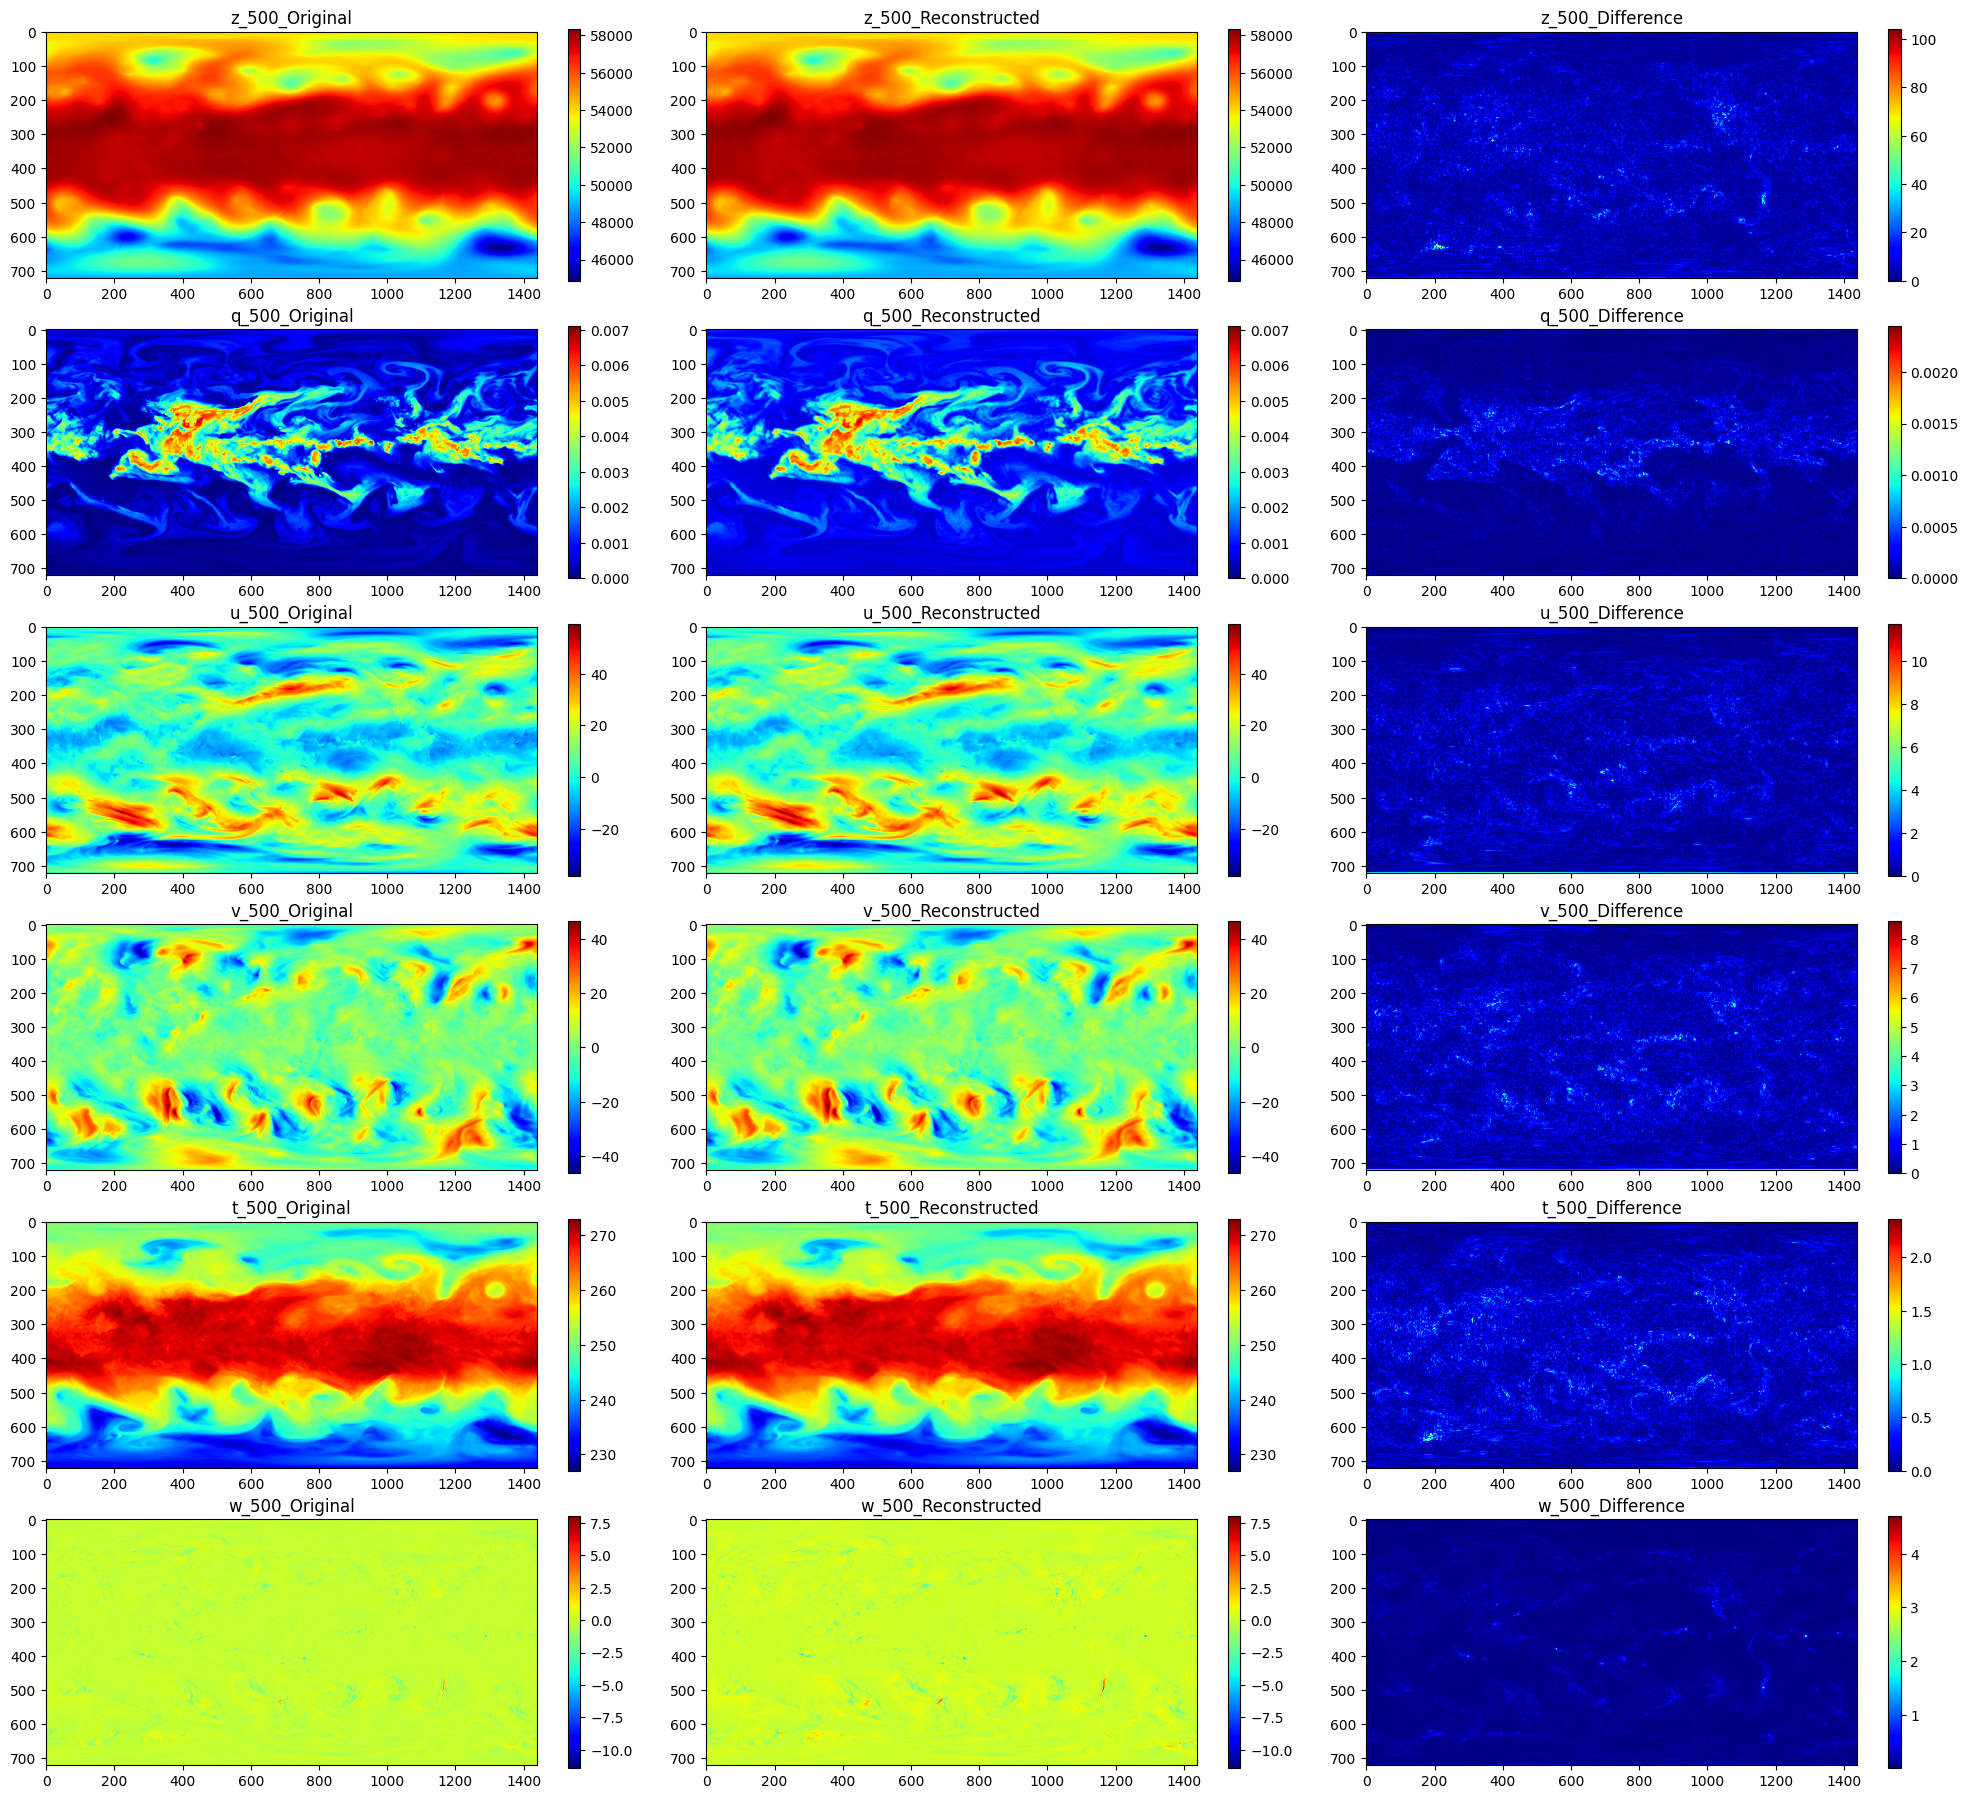

In [7]:
import numpy as np
import matplotlib.pyplot as plt

vis_vnames = ['z_500', 'q_500', 'u_500', 'v_500', 't_500', 'w_500']

vis_data_list = []
for vname in vis_vnames:
    data_ori = input_data[vname_to_channels[vname]]
    data_rec = reconstruct_data[vname_to_channels[vname]]
    diff = np.abs(data_ori - data_rec)
    vis_data_list.append([data_ori, data_rec, diff])
print(vis_data_list)

fig, axs = plt.subplots(len(vis_vnames), 3, figsize=( 20, 3*len(vis_vnames)))

for i, data in enumerate(vis_data_list):
    # original data
    im0 = axs[i, 0].imshow(data[0], cmap='jet')
    axs[i, 0].set_title(f'{vis_vnames[i]}_Original')
    fig.colorbar(im0, ax=axs[i, 0])
    
    #reconstrcted data
    axs[i, 1].imshow(data[1], cmap='jet')
    axs[i, 1].set_title(f'{vis_vnames[i]}_Reconstructed')
    fig.colorbar(im0, ax=axs[i, 1])
    
    #difference
    im2  = axs[i, 2].imshow(data[2], cmap='jet')
    axs[i, 2].set_title(f'{vis_vnames[i]}_Difference')
    fig.colorbar(im2, ax=axs[i, 2])
plt.tight_layout()

plt.show()

# 2. Latent visualization

In [8]:
def detailed_bpp(out):
    size = out['x_hat'].size()
    num_pixels = size[0] * size[1] * size[2] * size[3]
    for name, values in out_net['likelihoods'].items():
        bpp_val = torch.log(values).sum() / (-math.log(2) * num_pixels)
        print(f'- "{name}" latent bit-rate: {bpp_val:.5f} bpp')
               
detailed_bpp(out_net)

- "y" latent bit-rate: 0.07008 bpp
- "z" latent bit-rate: -0.00000 bpp


In [9]:
with torch.no_grad():
    y, y_hat, y_likelihoods = net.encode_latent(x)
    print(y.size(), y_hat.size(), y_likelihoods.size())
    
    print(y)
    print(y_hat)
    print(y_likelihoods)

torch.Size([1, 256, 72, 144]) torch.Size([1, 256, 72, 144]) torch.Size([1, 256, 72, 144])
tensor([[[[  0.5709,   0.9735,   1.3070,  ...,  -1.7625,  -1.4322,  -0.2990],
          [ -6.2588,  -4.7993,  -3.3295,  ...,  -8.4976,  -9.3549,  -8.9508],
          [-12.5836,  -8.7635,  -5.4550,  ..., -15.3996, -16.4783, -16.1593],
          ...,
          [-35.5907, -33.7575, -22.1796,  ..., -16.2554, -22.7591, -30.6424],
          [-30.8472, -26.9794, -25.9350,  ..., -35.0672, -35.1998, -32.8557],
          [-35.1666, -34.6553, -33.9186,  ..., -33.8810, -34.4523, -34.5820]],

         [[ 18.9895,  16.8282,  15.1422,  ...,  22.2347,  21.4278,  19.9969],
          [ 24.8357,  21.6204,  19.6018,  ...,  16.5375,  22.6820,  24.8508],
          [-14.9394, -17.6550, -16.2641,  ...,  -2.7785,  -5.0454, -12.2610],
          ...,
          [-15.8116, -17.7726, -27.3908,  ..., -14.6435, -21.1689, -19.8811],
          [ 23.3896,  26.2180,  28.8070,  ...,   9.5469,  13.9750,  17.0366],
          [-31.1002,

### Per channel estimated bit-rate

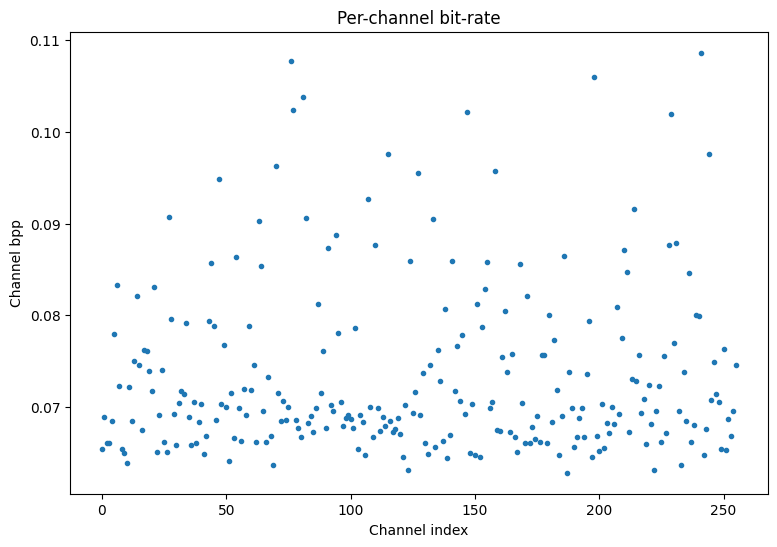

In [10]:

num_pixels = x.size(2) * x.size(3)

channel_bpps = [torch.log(y_likelihoods[0, c]).sum().item() / (-math.log(2) * num_pixels)
                for c in range(y.size(1))]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

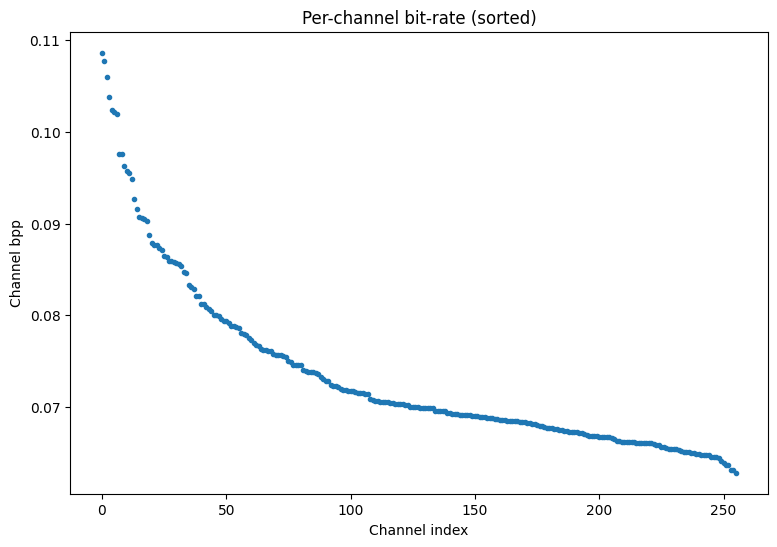

In [11]:
num_pixels = x.size(2) * x.size(3)

ordered_idxs = torch.argsort(torch.Tensor(channel_bpps), descending=True)
ordered_channel_bpps = torch.Tensor(channel_bpps)[ordered_idxs]

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(ordered_channel_bpps, '.')
ax.title.set_text('Per-channel bit-rate (sorted)')
ax.set_xlabel('Channel index')
ax.set_ylabel('Channel bpp')
plt.show()

### Interactive per-channel visualization

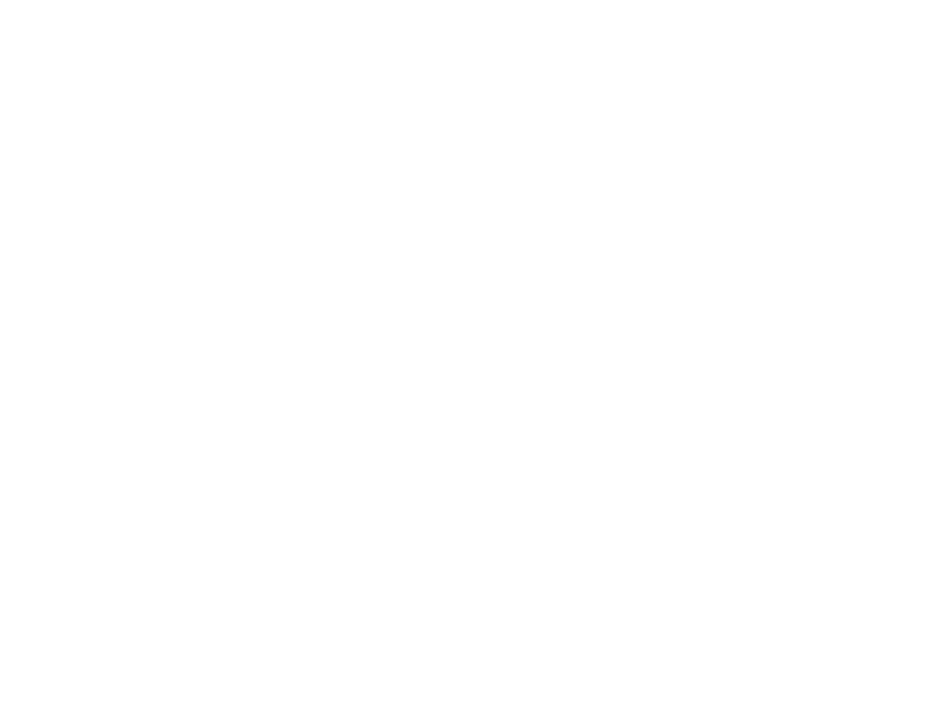

In [12]:
from IPython.display import display, clear_output
from ipywidgets import interact, widgets


fig, axes = plt.subplots(1, 2, figsize=(12, 9))
for ax in axes:
    ax.axis('off')

out = widgets.Output()
def show_channel(c):
    channel = y[0, ordered_idxs[c]].cpu()
    axes[0].imshow(channel)
    axes[0].title.set_text(f'Y | min: {channel.min():.2f} | max: {channel.max():.2f}')
    
    channel = y_hat[0, ordered_idxs[c]].cpu()
    axes[1].imshow(channel)
    axes[1].title.set_text(f'Y_hat | min: {channel.min():.2f} | max: {channel.max():.2f}')
    with out:
        clear_output(wait=True)
        display(fig)

In [13]:
slider = widgets.IntSlider(min=0, max=y.size(1)-1, step=1,continuous_update=False, description='Channel idx')
slider.observe(lambda ev: show_channel(slider.value))
show_channel(0)
display(widgets.VBox([out, slider]))

### Quantized vs continuous latent

In [22]:
with torch.no_grad():
    x_hat_y = net.decode_latent(y)
    x_hat_y_hat = net.decode_latent(y_hat)
x_hat_y = de_normalization(x_hat_y.squeeze().cpu().numpy())
x_hat_y_hat = de_normalization(x_hat_y_hat.squeeze().cpu().numpy()) 
print(x_hat_y.shape, x_hat_y_hat.shape)

/mnt/petrelfs/hantao.dispatch/anaconda3/envs/nwp/lib/python3.10/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


(268, 721, 1440) (268, 721, 1440)


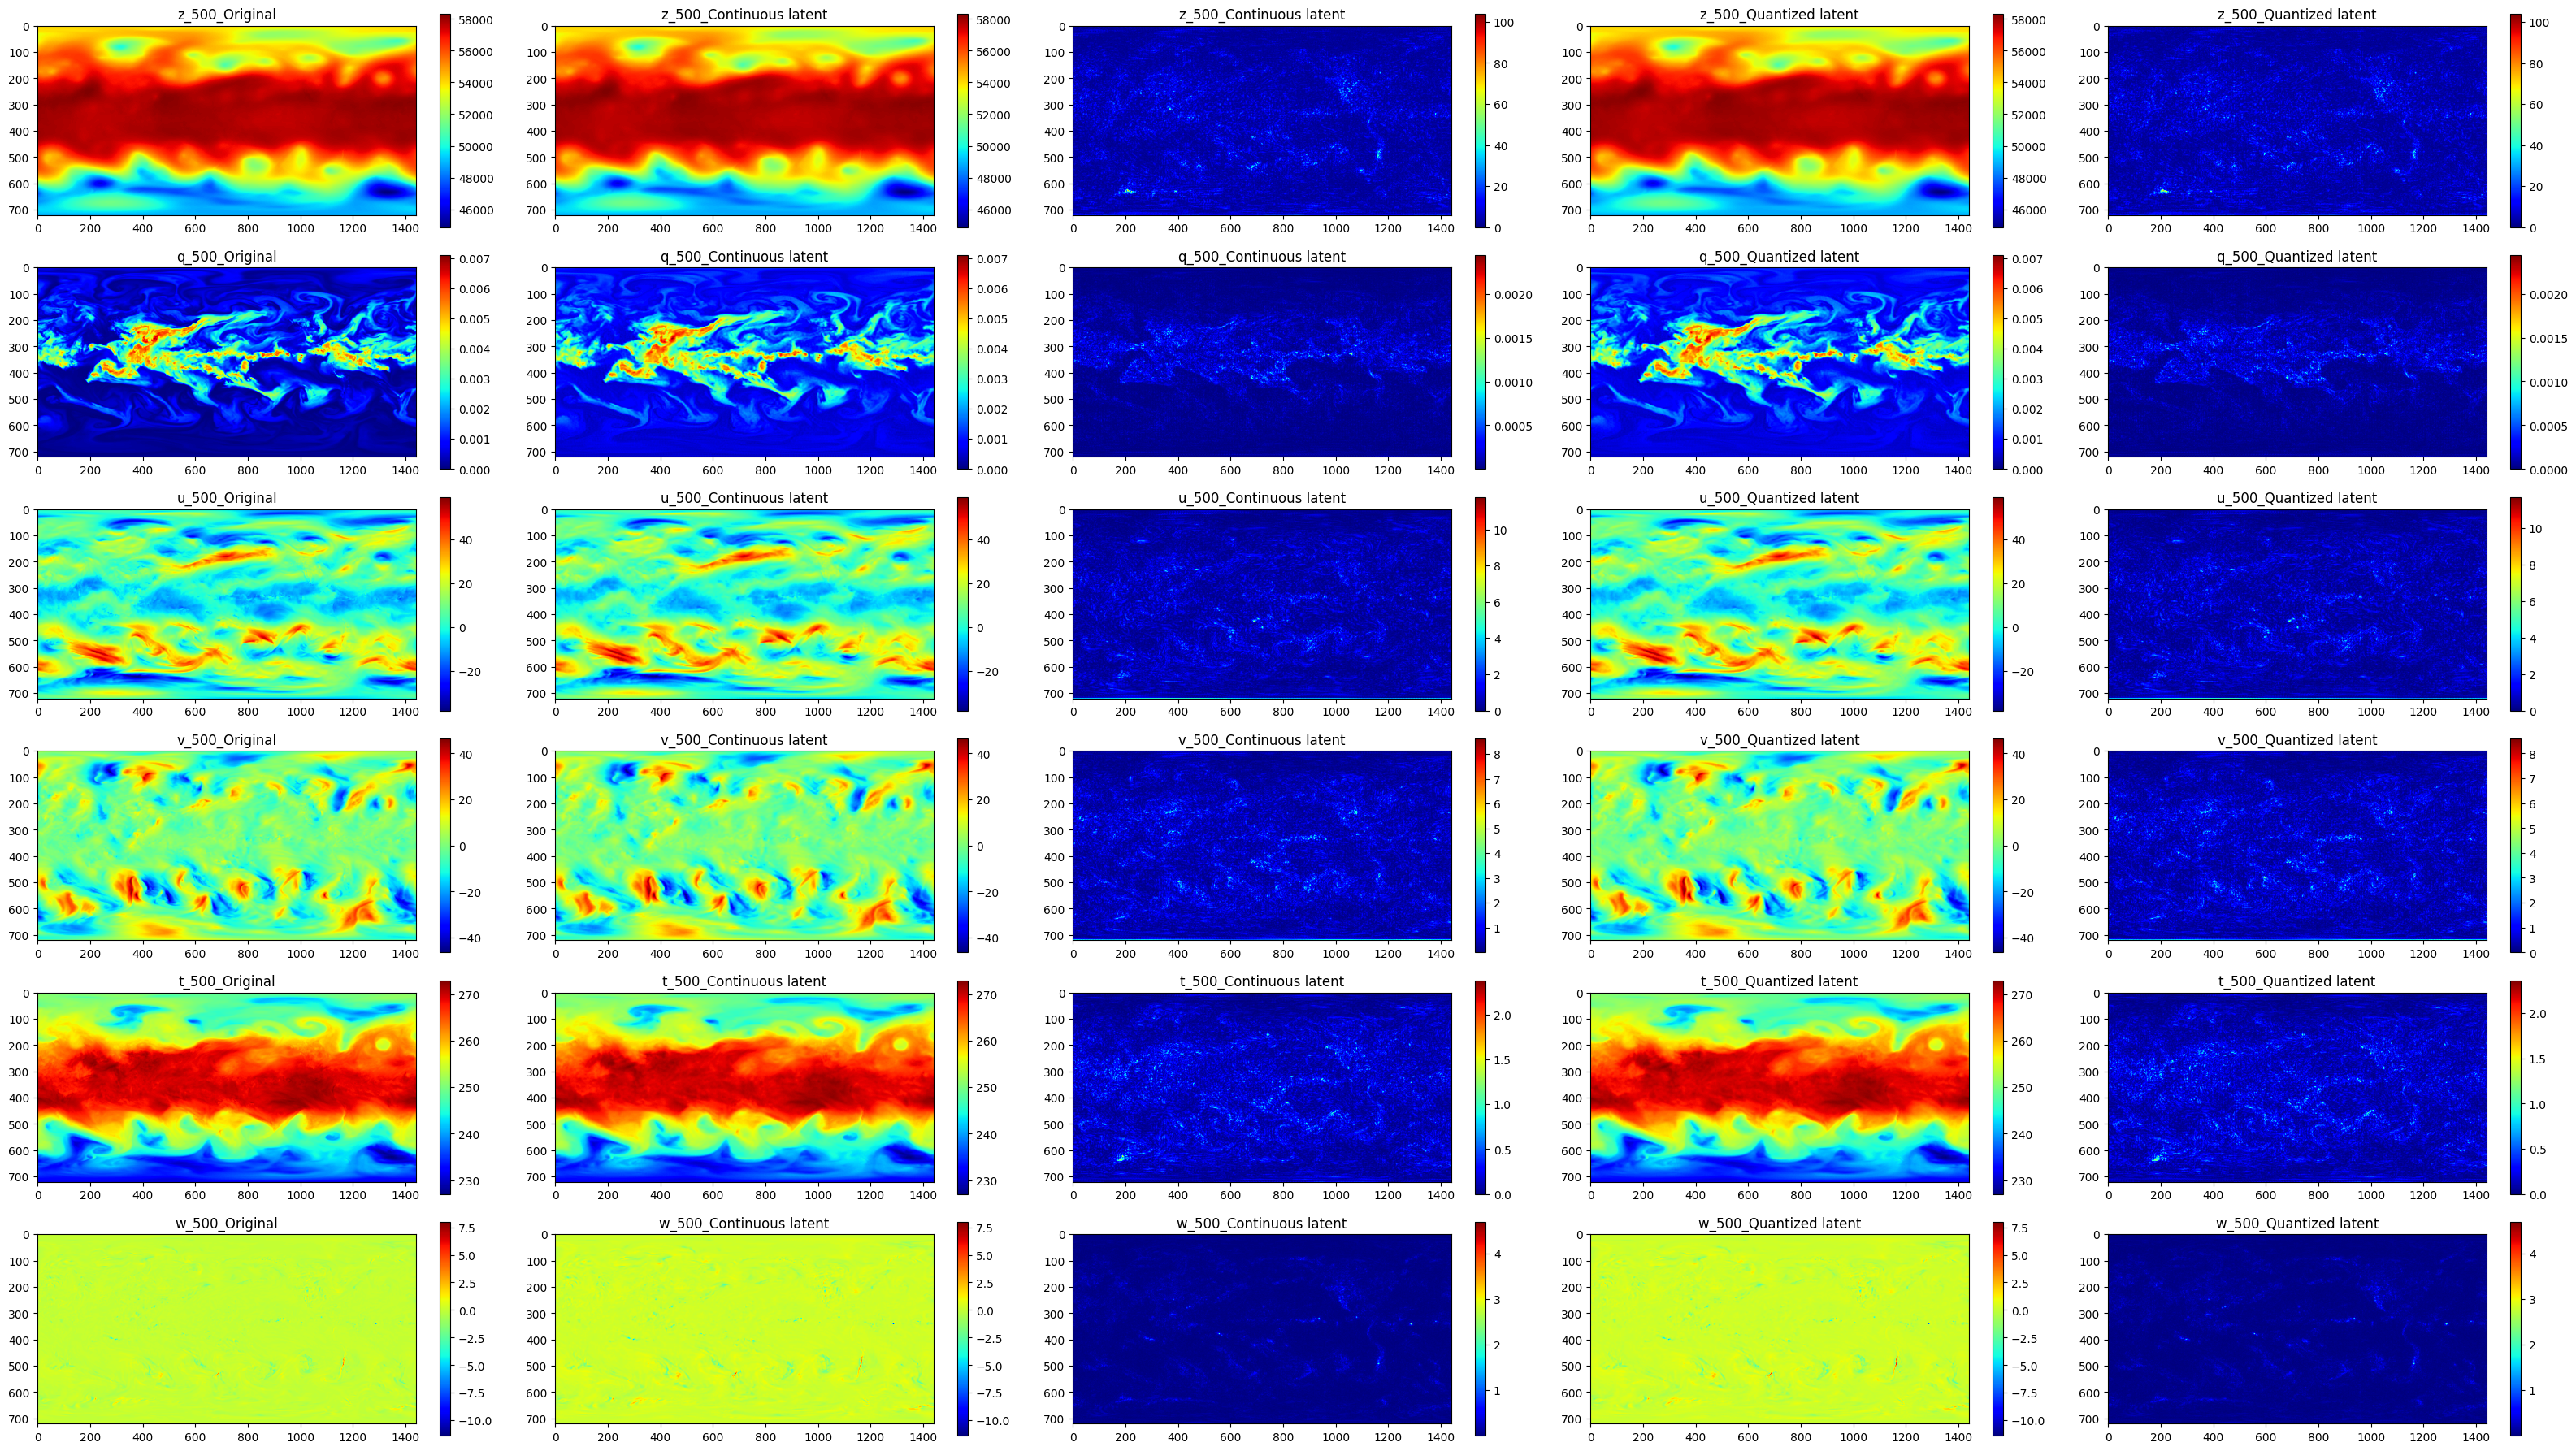

In [29]:
import numpy as np
import matplotlib.pyplot as plt

vis_vnames = ['z_500', 'q_500', 'u_500', 'v_500', 't_500', 'w_500']

vis_data_list = []
for vname in vis_vnames:
    data_ori = input_data[vname_to_channels[vname]]
    data_rec_continue = x_hat_y[vname_to_channels[vname]]
    data_rec_quantized = x_hat_y_hat[vname_to_channels[vname]]
    
    diff_continue = np.abs(data_ori - data_rec_continue)
    diff_quantized = np.abs(data_ori - data_rec_quantized)
    vis_data_list.append([data_ori, data_rec_continue, diff_continue, data_rec_quantized, diff_quantized])
    

fig, axs = plt.subplots(len(vis_vnames), 5, figsize=( 32, 3*len(vis_vnames)))

for i, data in enumerate(vis_data_list):
    # original data
    im0 = axs[i, 0].imshow(data[0], cmap='jet')
    axs[i, 0].set_title(f'{vis_vnames[i]}_Original')
    fig.colorbar(im0, ax=axs[i, 0])
    
    #Continuous latent 
    axs[i, 1].imshow(data[1], cmap='jet')
    axs[i, 1].set_title(f'{vis_vnames[i]}_Continuous latent')
    fig.colorbar(im0, ax=axs[i, 1])
    
    #difference
    im2  = axs[i, 2].imshow(data[2], cmap='jet')
    axs[i, 2].set_title(f'{vis_vnames[i]}_Continuous latent')
    fig.colorbar(im2, ax=axs[i, 2])
    
    
    
    #Continuous latent
    axs[i, 3].imshow(data[3], cmap='jet')
    axs[i, 3].set_title(f'{vis_vnames[i]}_Quantized latent')
    fig.colorbar(im0, ax=axs[i, 3])
    
    #difference
    im2  = axs[i, 4].imshow(data[4], cmap='jet')
    axs[i, 4].set_title(f'{vis_vnames[i]}_Quantized latent')
    fig.colorbar(im2, ax=axs[i, 4])
    
plt.tight_layout()

plt.show()